In [1]:
from data import SignalingGameDataModule
from model import SignalingGameModule
from pytorch_lightning import Trainer
from eval import find_best_checkpoint

def load_checkpoint(run_folder):
    checkpoint_path = find_best_checkpoint(run_folder)
    model = SignalingGameModule.load_from_checkpoint(checkpoint_path)
    return model

def eval_checkpoint(model):
    config = model.params

    config["max_epochs"]=-1
    config["num_workers"]=8

    datamodule = SignalingGameDataModule(num_attributes=config.num_attributes,
                                             num_values=config.num_values,
                                             max_num_objects=config.max_num_objects,
                                             test_set_size=config.test_set_size,
                                             batch_size=config.batch_size,
                                             num_workers=config.num_workers)
    trainer = Trainer.from_argparse_args(config)

    test_results = trainer.test(model=model, datamodule=datamodule, verbose=False)
    val_results = trainer.validate(model=model, datamodule=datamodule, verbose=False)
    return val_results, test_results



In [8]:
import os
log_dir = os.path.expanduser("~/lis-cluster/emergent_communication/emergent_communication/lightning_logs/")

runs = os.listdir(log_dir)
results_4_4_2_agents = []
attributes = 4
values = 4
for run in runs:
    run_folder = os.path.join(log_dir, run)

    run_id = int(run.replace("version_", ""))
    if 1052353 <= run_id < 99999999999:
        print(f"Checking {run}")

        try:
            model = load_checkpoint(run_folder)
        except FileNotFoundError:
            print(f"No checkpoints found for {run}")
            continue

        config = model.params
        if config.num_attributes == attributes and config.num_values == values:
            val_results, test_results = eval_checkpoint(model)
            results_4_4_2_agents.append((run_id, config, val_results, test_results))

In [6]:
len(results_4_4_2_agents)

0

<AxesSubplot:xlabel='clarification_requests', ylabel='val_acc'>

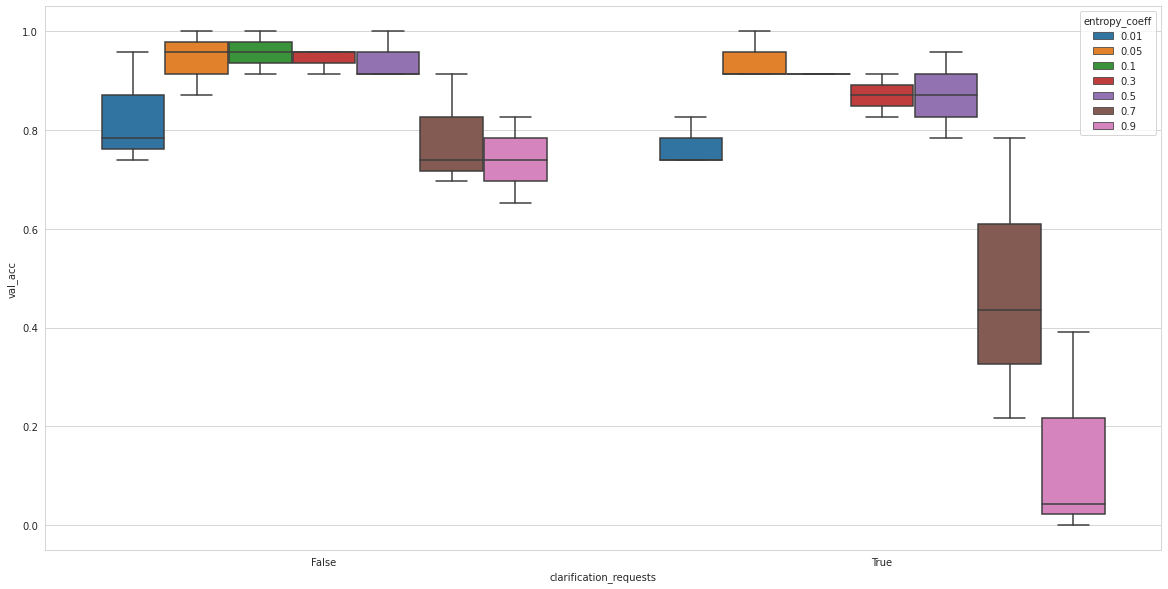

In [28]:
import pandas as pd

df = []
for res in results_4_4_noise_0_2:
    run_id, config, val_results, test_results = res
    df.append({
        "clarification_requests": config["clarification_requests"],
        "test_acc": test_results[0]["test_acc_no_noise"],
        "val_acc": val_results[0]["val_acc_no_noise"],
        "topsim": test_results[0]["topsim_at_best_val_acc"],
        "entropy_coeff": config["sender_entropy_coeff"],
    })

df = pd.DataFrame(df)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
# sns.swarmplot(data=df, x="clarification_requests", y="test_acc_no_noise", hue="entropy_coeff")
sns.boxplot(data=df, x="clarification_requests", y="val_acc", hue="entropy_coeff")